# Ladybug classification

In this notebook, we will try to classify ladybugs using a simple machine learning model, our goal is still to classy our ladybug but making it in a way that we can easily understand the result. The dataset contains extracted features from images of ladybugs, such as color of the shell, number and brightness of the spots.

We will start by testing with a Random Forest model, then we will try other models to see if they perform better.

First, let's  import the necessary libraries and prepare the dataset.

## 1. Preparing the Dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from PIL import Image

We will label encode our categorical features and use a Random Forest Classifier to classify the ladybug species based on the extracted features.
We will also use GridSearchCV to find the best hyperparameters for our model.

In [3]:
#Training data
df = pd.read_csv("training_labels_completed.csv")

X = df.drop(columns=["Image_id", "Label"])
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Test data
test_df = pd.read_csv("test_labels_completed.csv")

X_test_real = test_df.drop(columns=["Image_id", "Label"])
y_test_real = test_df["Label"]

#Pipeline and preprocessing
categoricalCols = ["shell_brightness", "spots_brightness"]
numericalCols = ["spots_number"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(), categoricalCols)
], remainder="passthrough")


## 2. Random Forest Classifier

### A. Training

Now that our dataset is prepared, we can start by training a Random Forest Classifier. We will run a grid search to find the best hyperparameters for our model.

In [4]:
pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

param_grid = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1, 2],
    "classifier__criterion": ["gini", "entropy"]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}
Best Cross-Validated Accuracy: 0.925


We can now use the optimal hyperparameters to train a Random Forest Classifier on the training dataset and test it.

In [5]:
bestParams = grid_search.best_params_

rf_best = RandomForestClassifier(
    n_estimators=bestParams["classifier__n_estimators"],
    max_depth=bestParams["classifier__max_depth"],
    min_samples_split=bestParams["classifier__min_samples_split"],
    min_samples_leaf=bestParams["classifier__min_samples_leaf"],
    criterion=bestParams["classifier__criterion"],
    random_state=42
)

final_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", rf_best)
])

final_pipeline.fit(X_train, y_train)

y_pred = final_pipeline.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.95

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.95      0.95      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



We can observe that our model has a high accuracy of 0.95 on this set, which is a pretty good result. We can 

### B. Testing

Now that our model is trained, we can test it on the test dataset. We will use the same preprocessing steps as before and then evaluate the model's performance on the test set.

In [6]:
y_pred_test = final_pipeline.predict(X_test_real)

print("Test Dataset Accuracy:", accuracy_score(y_test_real, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test_real, y_pred_test))

Test Dataset Accuracy: 0.92

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        25
           1       0.96      0.88      0.92        25

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50



We can observe a global precision of 0.92, which indicates two things:
- The model is performing a little worse than on our training data.
- Our features extraction is good enough to classify ladybugs with a high precision.

We now will display images wrongly classified as well as their extracted features, we will try to make coherent hypothesis about why the model made these mistakes and if our features extraction can be improved to avoid these mistakes in the future.

Showing misclassifications for model: Random Forest
Total misclassified samples: 4



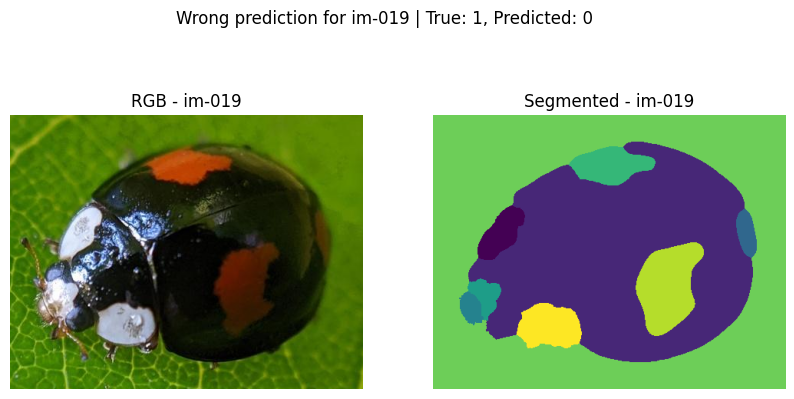

→ Extracted features :
shell_brightness    dark
spots_number         8.0
spots_brightness    dark
Name: 18, dtype: object


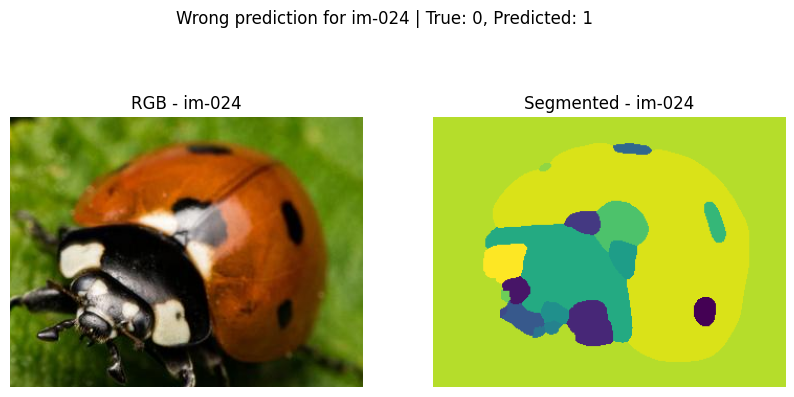

→ Extracted features :
shell_brightness    not dark
spots_number            16.0
spots_brightness        dark
Name: 23, dtype: object


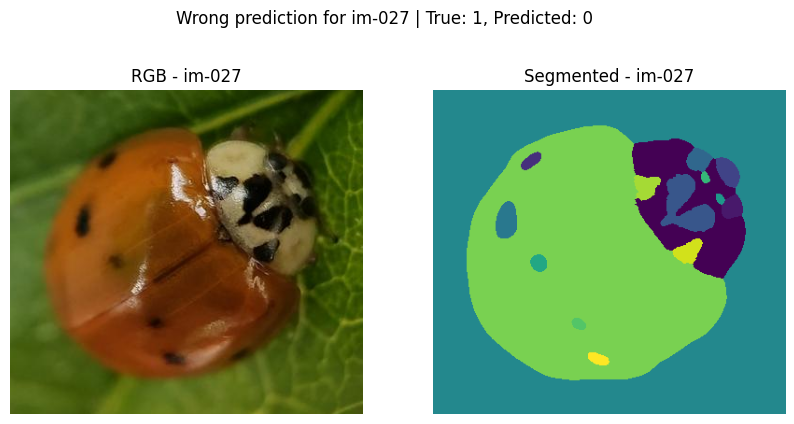

→ Extracted features :
shell_brightness    dark
spots_number        14.0
spots_brightness    dark
Name: 26, dtype: object


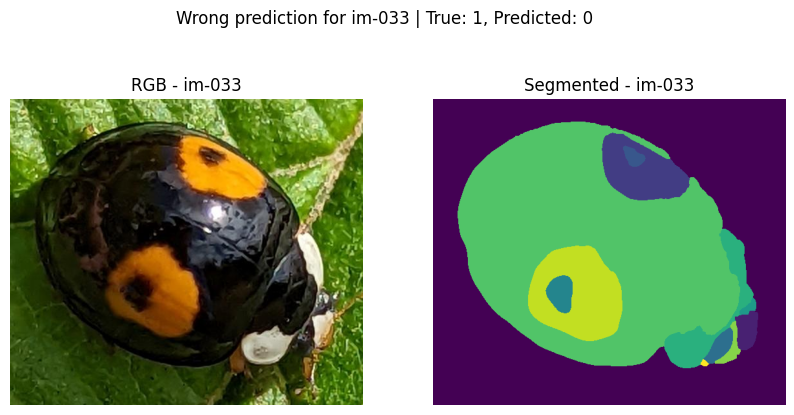

→ Extracted features :
shell_brightness    dark
spots_number        10.0
spots_brightness    dark
Name: 32, dtype: object


In [7]:
def display_wrong_predictions(y_pred_test,modelName="Random Forest"):
    wrongIndices = (y_pred_test != y_test_real).to_numpy().nonzero()[0]
    print(f"Showing misclassifications for model: {modelName}")
    print(f"Total misclassified samples: {len(wrongIndices)}\n")
    for idx in wrongIndices:
        image_id = test_df.iloc[idx]["Image_id"]
        features = test_df.iloc[idx].drop(["Image_id", "Label"])
        true_label = y_test_real.iloc[idx]
        predicted_label = y_pred_test[idx]

        segment_path = f"D:/Github/ladybug/test/{image_id}_seg.png"
        rgb_path = f"D:/Github/ladybug/test/{image_id}_im.png"

        rgbImg = Image.open(rgb_path)
        segImg = Image.open(segment_path)

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(rgbImg)
        axes[0].set_title(f"RGB - {image_id}")
        axes[0].axis("off")

        axes[1].imshow(segImg)
        axes[1].set_title(f"Segmented - {image_id}")
        axes[1].axis("off")

        plt.suptitle(f"Wrong prediction for {image_id} | True: {true_label}, Predicted: {predicted_label}", fontsize=12)
        plt.show()

        print("→ Extracted features :")
        print(features)
        print("=======================================================")
display_wrong_predictions(y_pred_test)

With this, we can start to think about why model might have some difficulties. But before going further, we will try other models to see if the results are better.

## 3. Testing other models

### A. Testing different classifiers

We will stick to our goal to make a model that is easy to understand, so we will try a Decision Tree Classifier, a logistic regression, a K-Nearest Neighbors Classifier, a Naive Bayes Classifier and a Support Vector Machine Classifier. We will use the same preprocessing steps as before and then evaluate the model's performance on the test set.

In [8]:
models_and_params = {
    "Decision Tree": (
        DecisionTreeClassifier(random_state=42),
        {
            "classifier__max_depth": [2, 4, 6, 8, 10, None],
            "classifier__min_samples_split": [2, 5, 10],
            "classifier__criterion": ["gini", "entropy"]
        }
    ),
    "Logistic Regression": (
        LogisticRegression(max_iter=1000),
        {
            "classifier__C": [0.01, 0.1, 1, 10, 100],
            "classifier__penalty": ["l2"],
            "classifier__solver": ["lbfgs"]
        }
    ),
    "KNN": (
        KNeighborsClassifier(),
        {
            "classifier__n_neighbors": [1, 3, 5, 7],
            "classifier__weights": ["uniform", "distance"]
        }
    ),
    "Naive Bayes": (
        GaussianNB(),
        {}
    ),
    "LDA": (
        LinearDiscriminantAnalysis(),
        {}
    )
}

for name, (model, param_grid) in models_and_params.items():
    print(f"🔍 Training {name}...")

    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("classifier", model)
    ])

    if param_grid:
        grid = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    else:
        grid = pipeline

    if param_grid:
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        print("✅ Best Params:", grid.best_params_)
        print("📊 Cross-Val Accuracy:", grid.best_score_)
    else:
        grid.fit(X_train, y_train)
        best_model = grid
        print("📊 Model Trained (no tuning)")

    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"🎯 Test Accuracy: {acc:.4f}")
    print("📋 Classification Report:")
    print(classification_report(y_test, y_pred))
    print("=======================================================")


🔍 Training Decision Tree...
✅ Best Params: {'classifier__criterion': 'gini', 'classifier__max_depth': 6, 'classifier__min_samples_split': 10}
📊 Cross-Val Accuracy: 0.9125
🎯 Test Accuracy: 0.9500
📋 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.95      0.95      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40

🔍 Training Logistic Regression...
✅ Best Params: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
📊 Cross-Val Accuracy: 0.80625
🎯 Test Accuracy: 0.8000
📋 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        20
           1       0.80      0.80      0.80        20

    accuracy                           0.80        40
   macro avg       0.80   

Since the Decision tree classifier and the K-Nearest Neighbors Classifier performed well on our training data, we will also make them predict on the test data to see if the misclassifications are the same as the ones we observed with the Random Forest Classifier and would be due to our feature extraction.

### B. Going further with Decision Tree and K-Nearest Neighbors

In [9]:
decisionTreeModel = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", DecisionTreeClassifier(
        criterion="gini",
        max_depth=6,
        min_samples_split=10,
        random_state=42
    ))
])

decisionTreeModel.fit(X, y)

yPredDecisionTree = decisionTreeModel.predict(X_test_real)

print("Decision Tree on Final Test Set:")
print("Accuracy:", accuracy_score(y_test_real, yPredDecisionTree))
print("Classification Report:")
print(classification_report(y_test_real, yPredDecisionTree))

Decision Tree on Final Test Set:
Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        25
           1       0.96      0.92      0.94        25

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50



In [10]:
knnModel = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", KNeighborsClassifier(
        n_neighbors=3,
        weights="uniform"
    ))
])

knnModel.fit(X, y)

# Predict on final test set
yPredKNN = knnModel.predict(X_test_real)

print("KNN on Final Test Set:")
print("Accuracy:", accuracy_score(y_test_real, yPredKNN))
print("Classification Report:")
print(classification_report(y_test_real, yPredKNN))

KNN on Final Test Set:
Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        25
           1       0.96      0.92      0.94        25

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50



Lets display the images wrongly classified by the Decision Tree Classifier and the K-Nearest Neighbors Classifier, as well as their extracted features. 

### C. Exploring errors

We will display the images wrongly classified by the Decision Tree Classifier and the K-Nearest Neighbors Classifier, as well as their extracted features.

Showing misclassifications for model: Decision Tree
Total misclassified samples: 3



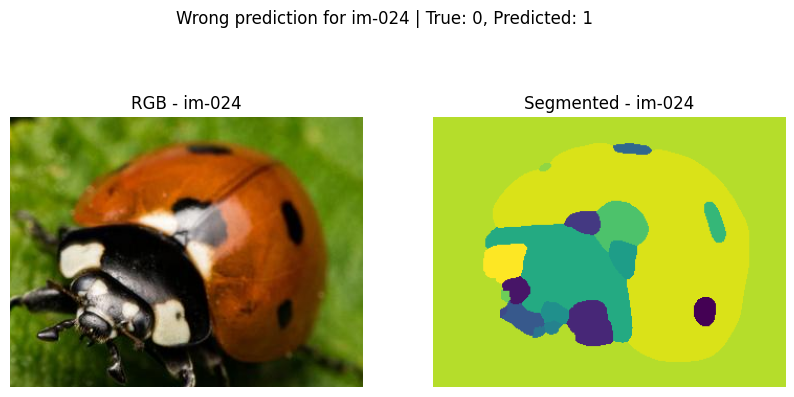

→ Extracted features :
shell_brightness    not dark
spots_number            16.0
spots_brightness        dark
Name: 23, dtype: object


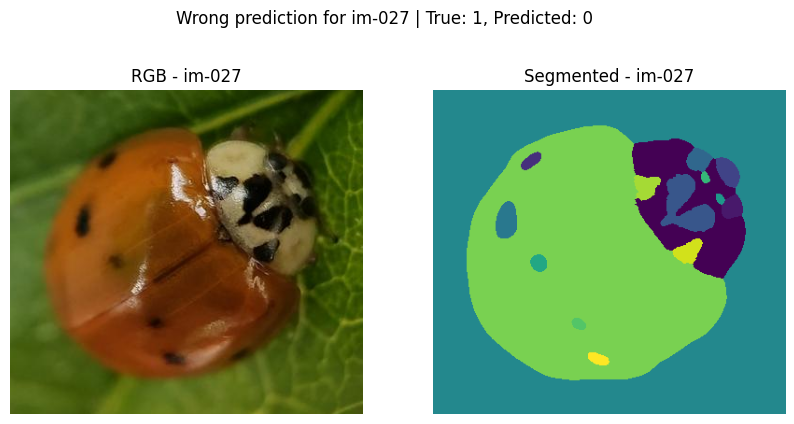

→ Extracted features :
shell_brightness    dark
spots_number        14.0
spots_brightness    dark
Name: 26, dtype: object


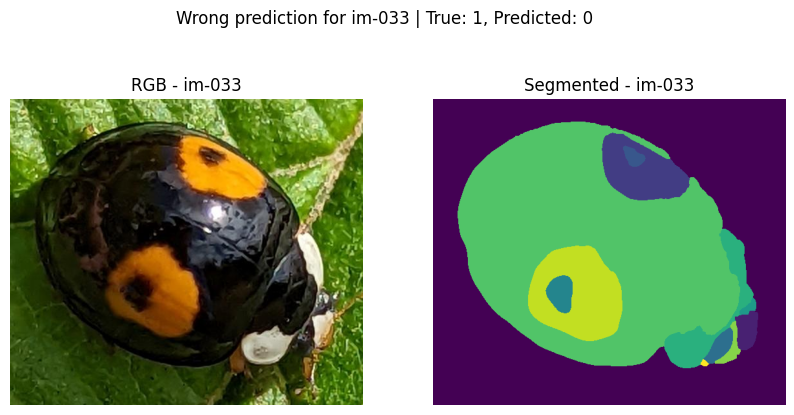

→ Extracted features :
shell_brightness    dark
spots_number        10.0
spots_brightness    dark
Name: 32, dtype: object


In [11]:
display_wrong_predictions(yPredDecisionTree , "Decision Tree")

Showing misclassifications for model: K-Nearest Neighbors
Total misclassified samples: 3



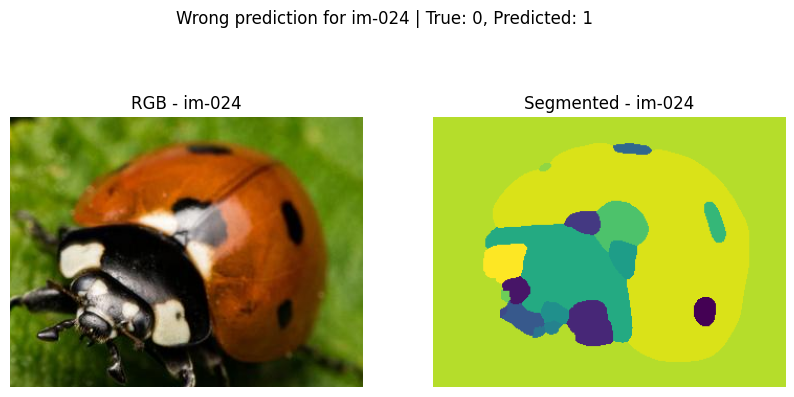

→ Extracted features :
shell_brightness    not dark
spots_number            16.0
spots_brightness        dark
Name: 23, dtype: object


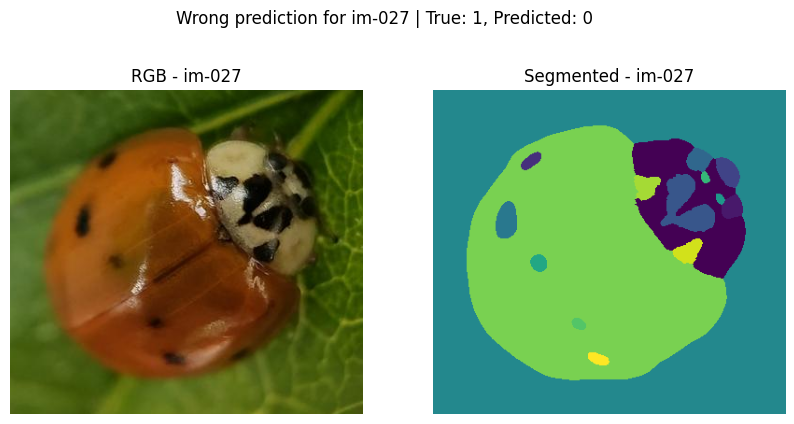

→ Extracted features :
shell_brightness    dark
spots_number        14.0
spots_brightness    dark
Name: 26, dtype: object


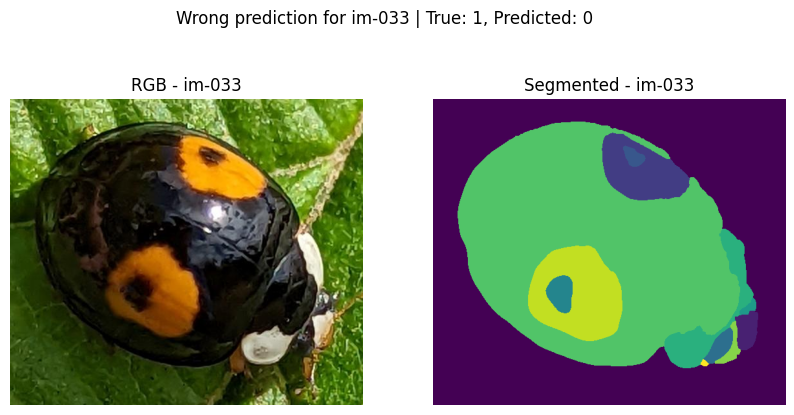

→ Extracted features :
shell_brightness    dark
spots_number        10.0
spots_brightness    dark
Name: 32, dtype: object


In [12]:
display_wrong_predictions(yPredKNN, "K-Nearest Neighbors")

We can observe that all our models (Random forest, Decision Tree and KNN) make the same 3 mistakes, and that random forest is doing 1 more mistake than the other two models. 

We can see a few things:

- After exploring the feature extraction for the 024, it is possible to observe that the head is not detected, and the points that were to be removed are not removed. So our feature extraction is not perfect, and it is highly possible that this error also happens on some training data.

- The error on the 027 is probably due to the fact that our feature extraction. Without the head, I would probably make the same mistake and classify it the same. The problem is probably that we have a shell brightness, a number and brightness of the spots that is very similar to any of the ladybugs from the species 0. A possible solution would be to complexify our feature extraction to try to detect the main color of the head, here it is white, which could help us to classify it as 1 since all ladybugs with a white head are from the species 1.

- Lastly, the error on the 033 is probably due to a too high number of spots detected. That could be due to the facts that some spots contains other spots that are counted twice while we would probably count them only once by ourselves, a solution would be to try to remove points contained in other points. Another potential problem is the head, that contains many spots spots and which we do not try to detect since the shell is dark, this seems to be a more complex problem and one of the only solution would be to build a complex feature extraction about the head: detecting if present, its orientation, its estimated size and then to try to extract the color of the head, as well as still removing unwanted points.

## 4. Explainability

Since our decision tree performed well on the test dataset, we can visualize it to understand how it makes its decisions.

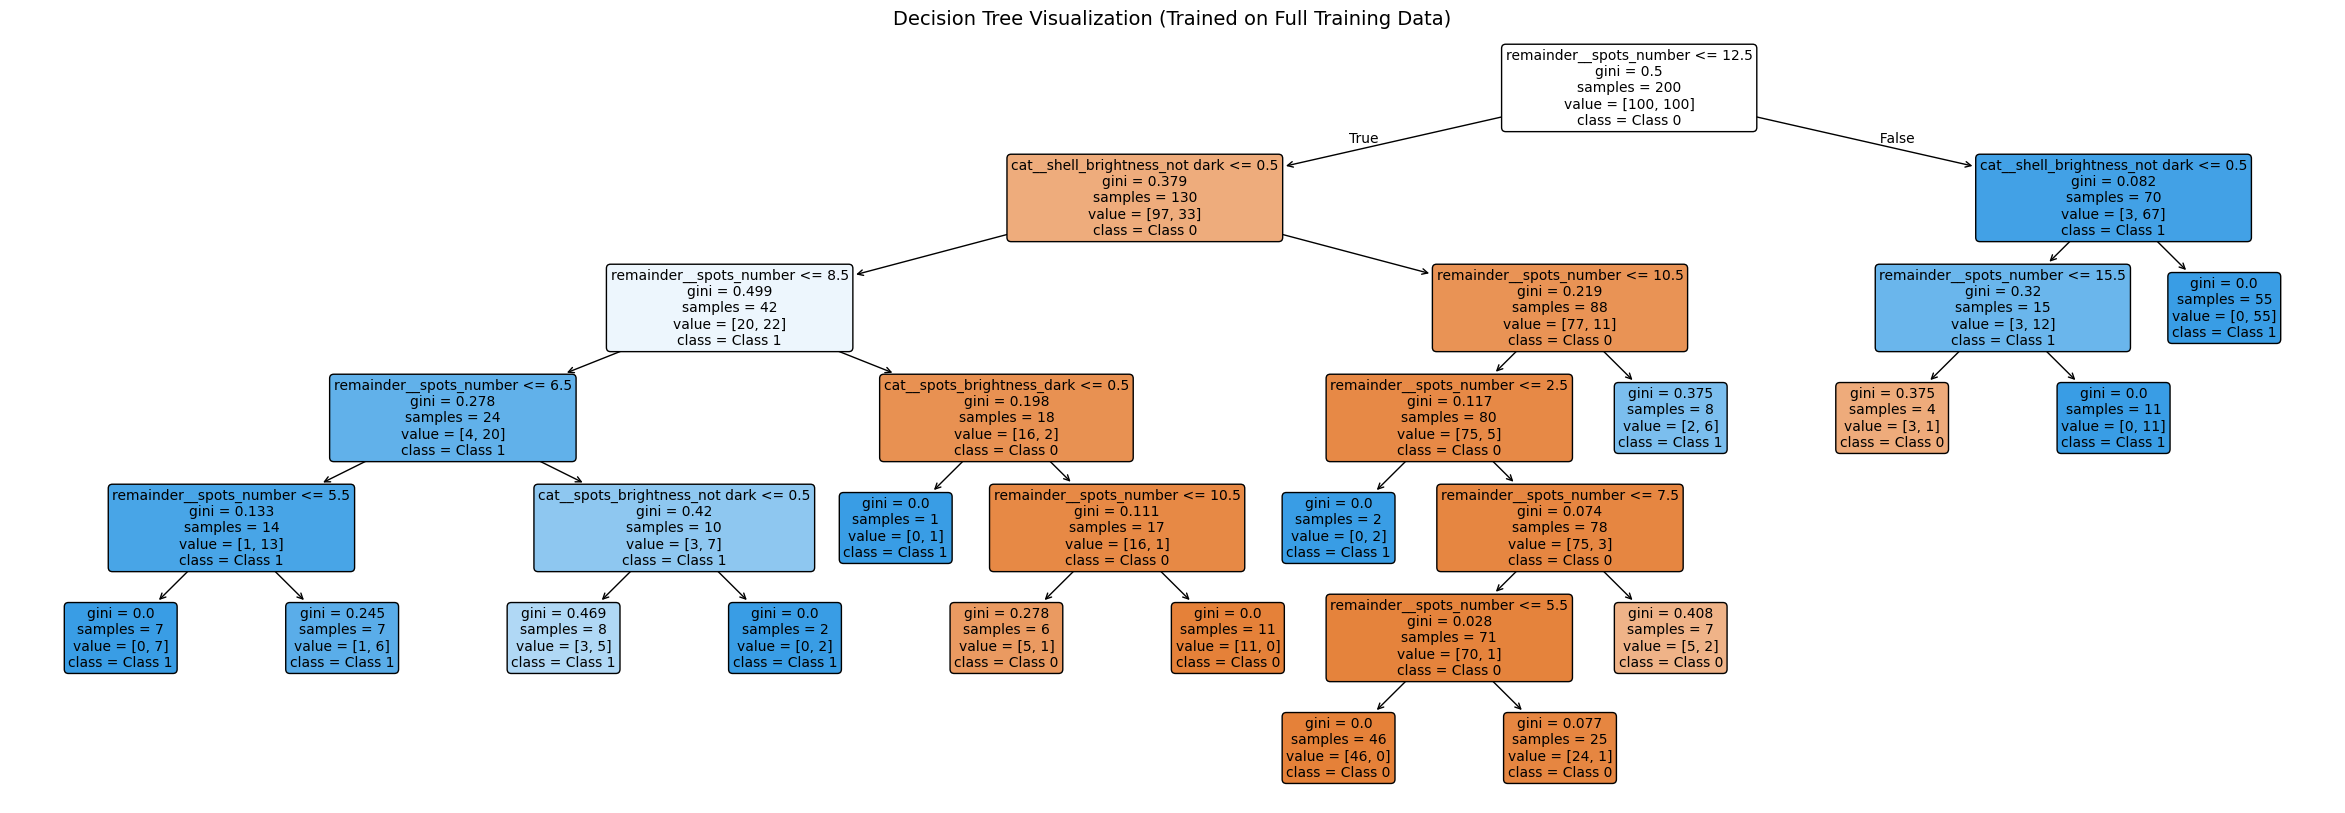

In [13]:
dtEstimator = decisionTreeModel.named_steps["classifier"]

featureNames = decisionTreeModel.named_steps["preprocessing"].get_feature_names_out()

plt.figure(figsize=(30, 10))
plot_tree(
    dtEstimator,
    feature_names=featureNames,
    class_names=["Class 0", "Class 1"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization (Trained on Full Training Data)", fontsize=14)
plt.show()

We can observe that the decision treee is relatively simple, with only a few nodes and relies a lot on the number of spots. The brightness of the shell come in second and the brightness of the spots is used only a few times. 

It is possible to notice a pretty much high number of spots in the nodes, it could mean that our feature extraction is not always ignoring the head part as intended. This can be improved by doing a different feature extraction, and maybe not ignoring what could be the head when too much centered, possibly leading to better results.

In [14]:
dtResults = test_df[["Image_id"]].copy()

dtResults["Label"] = yPredDecisionTree

dtResults.to_csv("predicted_labels.csv", index=False)

print("Predictions saved to 'predicted_labels.csv'")

Predictions saved to 'predicted_labels.csv'


# Conclusion

Our feature extraction has proven effective, allowing for precise ladybug classification. While a few consistent errors remain, they highlight areas for further refinement.

The model itself, though simple, delivers strong results and stands out for its transparency—its decision-making process is easy to interpret thanks to the visualized decision tree.